In [18]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from matplotlib import pyplot as plt

import os
from os.path import join
import sys
from IPython.display import display
from PIL import Image

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/datasets".format(ROOT_DIR)
print(DATASET_DIR)

/home/djoy2409-wsl/projects/software_development/tox_21_qsar/datasets


## Notes of Graph Convolutional Networks
<span style="font-family: cursive; font-size=14px">
<b>Graph Convolutional Networks (GCNs)</b> are a subclass of Graph Neural Networks (GNNs) that apply convolutions to the graph to produce a message, aggregating all neighbors of each node <em>v</em>, including the node itself and aggregating all information. The information. The graph convolution is generally followed by a pooling and/or readout, depending on the intended task (<a href="https://arxiv.org/pdf/1901.00596.pdf">Wu <em>et al.</em> 2019</a>). 
<ul>
<li>The pooling operation aims to reduce the size of parameters by down-sampling the nodes to generate smaller representations and thus avoid overfitting, permutation invariance, and computational complexity issues. A common way to transform each node's information to keep the range of different nodes comparable is through division by the node's degree, since nodes can have different number of neighbors. The authors of the GCN (Kipf et al. in 2016)  noticed that features from nodes with a lot of neighbors will spread much more easily than those from more isolated nodes. To counterbalance this effect, they proposed to give bigger weights to features from nodes with few neighbors.</li>
<li>The readout operation is mainly used to generate a graph-level representation based on node representations.</li>
</ul>
<br/>
<div class="image-title" style="text-align: center;">
    <img src="../../figures/gcn.png" width="850" height="400" alt="Wu et al.(2019)">
    <p style="font-size: 12px;">Wu <em>et al.</em>(2019)</p>
</div>
<br> CGNs provides several advantages, including:
<ol>
<li><b>Local Information Aggregation:</b> GCNs effectively capture local graph structure by aggregating information from neighboring nodes. This allows them to model node relationships within the immediate vicinity.</li>
<li><b>Parameter Sharing:</b>The graph convolution operation involves parameter sharing, meaning that the same set of weights is applied to all nodes in the graph. This sharing of parameters helps the model generalize well to different parts of the graph.</li>
</ol>

<br/>GCNs can suffer some limitations, regarding:
<ol>
<li><b>Depth and Over-Smoothing:</b> Deep GCNs may suffer from over-smoothing, where the representations of nodes become too similar after several layers, especially in the presence of large graphs.</li>
<li><b>Handling Graphs with Different Sizes:</b> GCNs assume a fixed-size neighborhood for each node. Handling graphs with varying sizes or irregular structures can be challenging, as the fixed-size aggregation may not capture the full extent of node relationships.</li>
<li><b>Sensitivity to Graph Perturbations:</b> This sensitivity may limit their robustness to noise or changes in the graph topology.</li>
<li><b>Lack of Edge Information:</b> For tasks that heavily rely on edge features, other GNN architectures like GraphSAGE or GAT may be more suitable.</li>
<li><b>Difficulty with Unattributed Graphs: </b> GCNs assume node features as input. For graphs without node features (unattributed graphs), they may not perform as well, and alternative architectures like Graph Isomorphism Networks (GIN) or GraphSAGE might be considered.</li>
</ol>
Moreover, mean-based aggregation, which is not injective. This means that different graphs can have the same embedding and thus, be undistinguisheable. Examples of GNNs thatt have been proposed to overcome the limitations of GCNs include Graph Isomorphism Neetworks (GINs), Graph Attention Networks (GATs), etc.

<br/>Good resources for learning abour GNNs inlcude:
<ol>
<li><a href="https://distill.pub/2021/understanding-gnns/">Understanding Convolutions on Graphs</a>
<li> <a href="https://github.com/chaitjo/geometric-gnn-dojo/tree/main">geometric-gnn-dojo</a>. Check the geometric_gnn_101.ipynb</li>
<li><a href="https://github.com/qbxlvnf11/graph-neural-networks-for-graph-classification">graph-neural-networks-for-graph-classification</a>
</ol>
</span>

In [3]:


from typing import List, Union, Any, Tuple
from datetime import datetime

import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch_geometric
from torch_geometric.data import Data

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw, AllChem
from IPython.display import display

from joblib import Parallel, delayed

RDLogger.DisableLog('rdApp.*')
from lib import gnn_utils, utilities, datasets

### Create Featurizers

In [4]:
from lib.gnn_utils import AtomFeaturizer, BondFeaturizer
ATOMIC_NUM_MAX = 100 ## We only consider atoms with a number of 100 or less (e.g.: 'H':1, 'C':6, 'O':8)
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "atomic_num": set(range(1, ATOMIC_NUM_MAX+1)),
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3", "sp3", "sp3d", "sp3d2"},
        "chiral_tag": {0,1,2,3},
        "is_aromatic": {True, False},
        "is_in_ring": {True, False}
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
        "stereo": {"stereonone, stereoz, stereoe, stereocis, stereotrans"}
    }
)

## Get dataset

In [5]:
input_df = pd.read_csv(join(DATASET_DIR, "compounds/nr-ahr.tab"), sep="\t") #sr-are.tab
smiles_column   = "SMILES"
target_column   = "activity"
print(input_df.shape)
input_df.head(2)

(1900, 3)


,Compound,SMILES,activity
0,NCGC00013051-01,CC(C)(C)c1cc(O)ccc1O,1
1,NCGC00013051-05,CC(C)(C)c1cc(O)ccc1O,1


In [6]:
# augmented = utilities.augment_data(input_df.head(2), smiles_column, target_column, n_randomizations=1)
# from rdkit.Chem import PandasTools
# PandasTools.AddMoleculeColumnToFrame(augmented, smiles_column, 'RMol', includeFingerprints=False)
# augmented

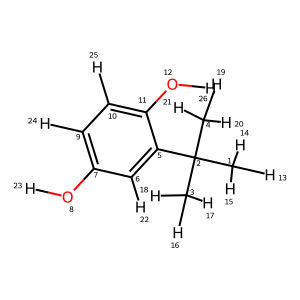

In [7]:
mol = utilities.molecule_from_smiles(input_df[smiles_column].values[0])
utilities.add_numbers_to_mol_atoms(mol)
display(Draw.MolToImage(mol, wedgeBonds=True, kekulize=True))

In [8]:
dataset = gnn_utils.get_dataset(input_df=input_df.iloc[:,:], smiles_column=smiles_column, target_column=target_column
                             , atom_featurizer=atom_featurizer, bond_featurizer=bond_featurizer
                             , add_explicit_h=True)
print(dataset[4].x.shape)

Converting SMILES to chemical graphs.:   0%|          | 8/1900 [00:00<00:24, 76.29it/s]

Converting SMILES to chemical graphs.: 100%|██████████| 1900/1900 [00:03<00:00, 492.86it/s] 


torch.Size([47, 133])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch_geometric.nn import GCNConv, Linear
from torch_geometric.data import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

import math

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.3):
        super(GCN, self).__init__()
        self.in_channels     = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels    = out_channels
        self.dropout_rate    = dropout_rate
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin  = Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)

        ## The readout layer takes in the node embeddings of all nodes in the mini-batch and the
        ## assignment vector batch to compute a graph embedding of size
        ## [batch_size, hidden_channels] for each graph in the batch.
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)
        
        return x
    

def train(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"device = {device}")
    
    criterion = nn.CrossEntropyLoss()
    val_accuracies, val_losses, train_losses = [], [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            data.x = data.x.float()
            output = model(data)
            # print("output.shape: ", output.shape)
            # print("output", output)
            loss = criterion(output.float(), data.y) # torch.as_tensor(data.y) # torch.reshape(data.y, (len(data.y), 1)); data.y
            # print(loss)
            loss.backward() ## Derive gradients.
            optimizer.step() ## Update parameters based on gradients.
            optimizer.zero_grad() ## Clear gradients.
            if not scheduler is None:
                scheduler.step
            total_loss += loss.item()

        average_train_loss = total_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            total_val_loss = 0
            for data in val_loader:
                data = data.to(device)
                data.x = data.x.float()
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += data.y.size(0)
                correct += (predicted == data.y).sum().item()

                val_loss = criterion(output.float(), data.y)
                total_val_loss += val_loss.item()
        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        accuracy = correct / total
        val_accuracies.append(accuracy )
        if epoch%20==0 or epoch == num_epochs-1:
            print(f"Epoch {epoch + 1:4d}/{num_epochs}: Average Train Loss: {average_train_loss:.3f} |  Average validation Loss: {average_val_loss:.3f} | Validation Accuracy: {accuracy * 100:.3f}")
    return train_losses, val_losses, val_accuracies



In [10]:
train_data, val_data, test_data = datasets.split_data(dataset, split_indices=None, train_ratio=0.75, val_ratio=0.15, test_ratio=0.1)
print(len(train_data), "\n", len(val_data), "\n", len(test_data))


batch_size=64
data_loaders = datasets.get_dataloaders(train_data, val_data, test_data, batch_size=batch_size, shuffle_train=True)

1425 
 285 
 190


### Training the GCN Model
<div style="font-family: cursive; font-size=14px">
Below, we will define our GCN model, and several parameters and objects that will enable us to train, validate, and test it. These include the optimizer and the leearning rate scheduler.</br>
<ul>
<li>The <b>optimizer</b> adjusts the learning parameters (weights and biases) of a model in order to minimize the error or loss function. The optimization process involves iteratively adjusting these parameters based on the gradients of the loss function with respect to the parameters. Examples of optimization algorithms include the <b>Stochastic Gradient Descent (SGD)</b>, <b>Adam</b>, <b>Adagrad</b>, etc.</li>
<li>The <b>learning rate scheduler</b> is a strategy or algorithm that adjusts the learning rate during training. Some examples include the <b>StepLR</b>, which the learning rate at fixed intervals (epochs), and the <b>ReduceLROnPlateau</b>, which monitors a specific metric(e.g. validation loss) and reduces the learning rate when the metric plateaus.</li>
</sdiv>

In [11]:
# Define the model
num_features    = train_data[0].x.shape[1]
num_classes     = len(set([i.y.item() for i in train_data ]))
hidden_channels = 256
dropout_rate    = 0.3
model = GCN(in_channels=num_features, hidden_channels=hidden_channels, out_channels=num_classes, dropout_rate=dropout_rate)

## Define other objects
lr = 0.01 # the proportion by which the model's parameters are updated during each iteration of the optimization algorithm
optimizer = optim.Adam(model.parameters(), lr=lr)

## Defining the learning rate scheduler
step_size = 100 # Number of steps after which the learning rate is updated
gamma     = 0.3    # The factor by which the learning rate is updated
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Adjust the step_size and gamma accordingly

# Train the model
num_epochs = 300
train_losses, val_losses, val_accuracies = train(model, data_loaders[0], data_loaders[1], optimizer, scheduler, num_epochs=num_epochs)



device = cuda
Epoch    1/300: Average Train Loss: 0.650 |  Average validation Loss: 0.499 | Validation Accuracy: 78.947
Epoch   21/300: Average Train Loss: 0.478 |  Average validation Loss: 0.463 | Validation Accuracy: 82.632
Epoch   41/300: Average Train Loss: 0.484 |  Average validation Loss: 0.440 | Validation Accuracy: 83.684
Epoch   61/300: Average Train Loss: 0.509 |  Average validation Loss: 0.398 | Validation Accuracy: 84.211
Epoch   81/300: Average Train Loss: 0.450 |  Average validation Loss: 0.422 | Validation Accuracy: 86.316
Epoch  101/300: Average Train Loss: 0.450 |  Average validation Loss: 0.444 | Validation Accuracy: 85.789
Epoch  121/300: Average Train Loss: 0.437 |  Average validation Loss: 0.455 | Validation Accuracy: 85.789
Epoch  141/300: Average Train Loss: 0.453 |  Average validation Loss: 0.438 | Validation Accuracy: 85.789
Epoch  161/300: Average Train Loss: 0.436 |  Average validation Loss: 0.435 | Validation Accuracy: 87.368
Epoch  181/300: Average Train Lo

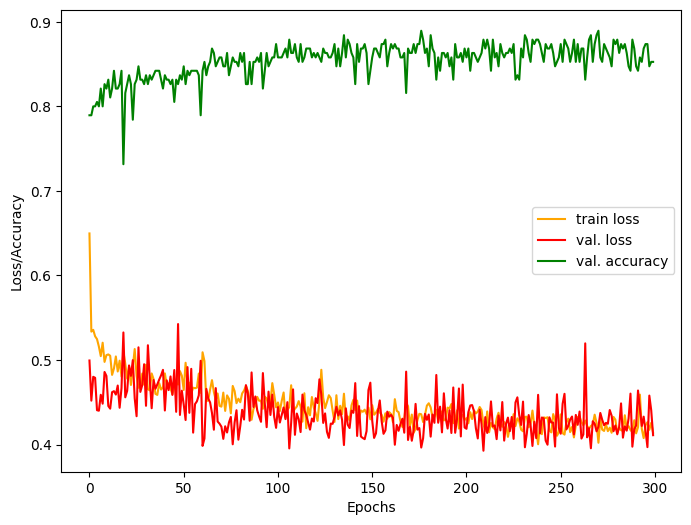

In [12]:
utilities.plots_train_val_metrics(train_losses=train_losses, val_losses=val_losses, val_accuracies=val_accuracies
                                  , figsize=(8,6)
                                  , image_pathname = "{}/figures/Losses by epoch".format(ROOT_DIR))

### Testingt the model
<p style="font-family: cursive; font-size=1px">
We will now implement and apply a function that will test the model and return metrics (average test lost, and accuracy), as well as the predicted class, and the actual class. 
</p>

In [13]:
@torch.no_grad()
def test(loader, model, loss_func=nn.CrossEntropyLoss(), device='cpu'):
    losses = []
    test_loss = 0
    pred_probas  = np.empty((0))
    pred_target = np.empty((0))
    true_target = np.empty((0))  
    total, correct = 0,0  

    for data in loader:
        data = data.to(device)
        data.x = data.x.float()
        output = model(data)
        loss = loss_func(output.float(), data.y)
        losses.append(loss.item())
        max_val, predicted = torch.max(output, 1) ## returns maximum values(_), and their indices (predicted) along the dimmension 1
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        pred_probas  = np.concatenate((pred_probas, max_val.cpu()))
        pred_target = np.concatenate((pred_target, predicted.cpu()))
        true_target = np.concatenate((true_target, data.y.detach().cpu().numpy()))
    
    accuracy = correct / total

    return round(accuracy, 3), round(np.asarray(losses).mean(), 3), pred_probas, pred_target, true_target




## Running the test
from sklearn.metrics import f1_score, roc_auc_score

accuracy, average_loss, pred_probas, pred_target, true_target = test(data_loaders[2], model, loss_func=nn.CrossEntropyLoss(), device='cuda')
print(f"{'Test Accuracy':18s} = {accuracy}\n{'Average Test Loss':18s} = {average_loss}\n{'Test F1-Score':18s} = {round(f1_score(true_target, pred_target), 3):.3f}\n{'Test ROC AUC':18s} = {round(roc_auc_score(true_target, pred_probas, average='weighted'), 3):.3f}")
print(f"{'Predicted class':18s}: {pred_target[:20]}")
print(f"{'Actual class':18s}: {true_target[:20]}")

Test Accuracy      = 0.796
Average Test Loss  = 0.705
Test F1-Score      = 0.815
Test ROC AUC       = 0.440
Predicted class   : [1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
Actual class      : [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]


### Predicting AhR Activity
<span style="font-family: cursive; font-size=16px">
Here, we will use the data loader generated previously for the test set. Three different functions were implemented for predicting our endpoint, from: 1) a list of SMILES string; 2) a list of graph (Data) objects, and 3) a data loader objects. Let's try these on the same dataset. As you can see below, the results are the same.
</span>

In [21]:


## Predict using a data loader
print("Predict using a data loader")
# test_loader = DataLoader(dataset=test, batch_size=batch_size)
test_loader = data_loaders[2] # Define below
print(gnn_utils.predict_from_loader(test_loader, model, device='cuda:0'))

## Predict from a graph data list
test = test_data[:10]
print("Predict from a graph data list")
print(gnn_utils.predict_from_data_list(test, model, batch_size=128, device='cuda:0'))

## Predicting from a list of smiles
print("Predicting from a list of smiles")
test_smiles = [d.smiles for d in test]
print(test_smiles[:5])
print(gnn_utils.predict_from_smiles_list(model, smiles_list=test_smiles, atom_featurizer=gnn_utils.ATOM_FEATURIZER
                             , bond_featurizer=gnn_utils.BOND_FEATURIZER
                             , batch_size=128, device='cuda:0', add_explicit_h=True))



Predict using a data loader
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
Predict from a graph data list
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Predicting from a list of smiles
['Oc1ccc

Converting SMILES to chemical graphs.: 100%|██████████| 10/10 [00:00<00:00, 2681.61it/s]

[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


### Suggestions to improve our model
<span style="font-family: cursive; font-size=16px">
<ol>
<li><b>Adding whole-molecular properties:</b> While standard GCNs focus on local neighborhood information, incorporating whole-graph properties allows the model to capture broader structural patterns and relationships within the entire graph. Examples of such features include, among others, the molecular weight, number of aromatic rings, LogP, topological polar surface areas, and number of hydrogen bond acceptors/donors. </li>
<li><b>Hyperparameter optimization:</b>This allows for efficient exploration of the different combinations of hyperparameters and optimzation of the model. Hyperparameter optimization can be carried out with tools such as Optuna, to help reduce overfitting, enhance generalization, and the model's robustness to variability.</li>
<li><b>Splitting technique:</b> K-fold cross-validation provides a robust estimate of model performance, since all data points are used for training and validation.
<p>By selecting molecules based on scaffold, one can reduce data leakage, as molecules with the same scaffold will be added to the same split. This will help to maximize the generalizability of he model. Moreover, scaffold splitting aligns with the decision-making process in medicinal chemistry, where predictions are often required for compounds with novel scaffolds.</p></li>
<li><b>Reducing the list of atomic numbers:</b> Generally, drug-like molecules are constituted of a small number of atom types, such as Carbon, Oxygen, and Nitrogen. Reducing the list of atomic number to the most relevant ones will help reducing the sparsity of the representation matrix, thus increasing the information density, which helps better understanding the underlying data, and developing more interpretable models. </li>
<li><b>Data augmentation:</b> Graph data augmentation introduces variations in the input graph structures. This helps the model become more robust to different graph topologies and variations in the data.</li>|
</ol>
</span>